- Check for Colab Env
> if we are in colab env we need to get the data + scripts from github or somewhere

In [1]:
import os
if "COLAB_GPU" in os.environ:
    _useMultiProcessing = False
    os.system("git clone https://github.com/zaxo7/UNet-Playground.git")
    os.chdir("/content/UNet-Playground/")
else:
    _useMultiProcessing = True
    
if "PAPERSPACE_FQDN" in os.environ:
    !apt update
    !apt install libgl1 -y
    !pip install opencv-python
    !git pull


Hit:1 http://security.ubuntu.com/ubuntu focal-security InRelease
Hit:2 http://archive.ubuntu.com/ubuntu focal InRelease
Hit:3 http://archive.ubuntu.com/ubuntu focal-updates InRelease
Hit:4 http://archive.ubuntu.com/ubuntu focal-backports InRelease
Reading package lists... Done3m
Building dependency tree       
Reading state information... Done
68 packages can be upgraded. Run 'apt list --upgradable' to see them.
^Cading package lists... 6%
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
^C


- enable module autoreload and fix an import bug

In [1]:
%load_ext autoreload
%autoreload 2


import sys,os
sys.path.append(os.getcwd() + '/scripts')

- import the scripts and data

In [2]:
from scripts import data, model
import glob
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from DataGenerator import DataGenerator

2022-05-22 16:16:05.430044: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/zaxo7/tensorflow/lib/python3.8/site-packages/cv2/../../lib64:
2022-05-22 16:16:05.430068: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


- load the dataset
- and ceate image slices

- slice each image to small samples of size 188*188
- imgs -> rgb image
- mask -> mask
- edge -> edge_mask

In [39]:
database = "data2"

_batch_size = 4

train_img_tile_files = sorted(glob.glob(f'{database}/train/*.jpg'))
train_mask_tile_label_files = sorted(glob.glob(f'{database}/train/WBC_mask/*.jpg'))

test_img_tile_files = sorted(glob.glob(f'{database}/test/*.jpg'))
test_mask_tile_label_files = sorted(glob.glob(f'{database}/test/WBC_mask/*.jpg'))


train_gen = DataGenerator(train_img_tile_files, train_mask_tile_label_files, train_mask_tile_label_files, _batch_size, skip_empty = False, slice=True)

test_gen = DataGenerator(test_img_tile_files, test_mask_tile_label_files, train_mask_tile_label_files, _batch_size, skip_empty = False, augment=False, slice=True)


#train = model.generate_train_dataset(train_img_files)

#train_generator = model.generate_train_dataset(train_img_files)

#train_set = model.generate_train_dataset_tf(train_img_files)



#test_img_chips, test_mask_chips, test_edge_chips = model.generate_test_dataset(test_img_files)

#train_img_chips, train_mask_chips, train_edge_chips = model.generate_test_dataset(train_img_files)



#test_set = model.generate_test_dataset_tf(test_img_files)



In [47]:
images, (masks, edges) = train_gen.__getitem__(100)

import cv2 
cv2.imwrite("test.png", masks[2] * 255)

data.plot_ime((images + 1) * 255 , masks, edges)

ModuleNotFoundError: No module named 'opencv'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


mask :  (array([0, 1, 2], dtype=uint8), array([4324013, 2508192,  181043]))
edge :  (array([0, 1, 2], dtype=uint8), array([6621817,  362288,   29143]))
mask :  (2344, 2992)
edge :  (2344, 2992)
img :  (2344, 2992, 3)


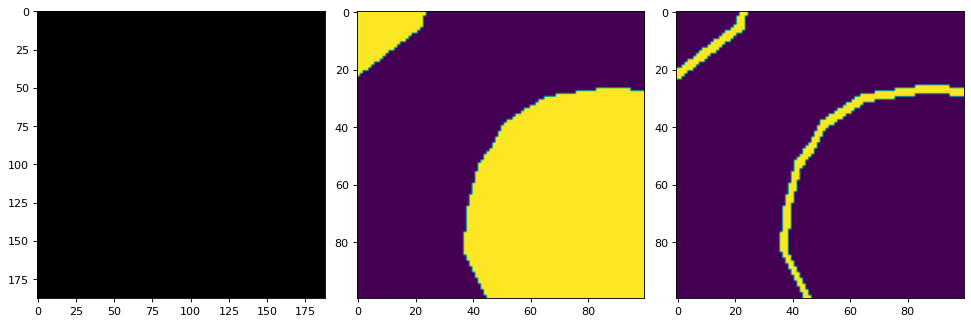

In [4]:
train_generator = model.generate_train_dataset(train_img_files)

train_img_chips, (train_mask_chips, train_edge_chips) =  next(train_generator)

fig = plt.figure(figsize=(15, 10), dpi=80)
fig.subplots_adjust(hspace=0.1, wspace=0.1)
ax = fig.add_subplot(2, 3, 1)
ax.imshow(train_img_chips)
ax = fig.add_subplot(2, 3, 2)
ax.imshow(np.squeeze(train_mask_chips))
ax = fig.add_subplot(2, 3, 3)
ax.imshow(np.squeeze(train_edge_chips))

- create the model and compile it

In [4]:
unet = model.get_do_unet(compile = False)

unet.compile(optimizer="adam",
             loss=model.tversky_loss_b,
             loss_weights=[0.3, 0.7],
             metrics={'mask': [model.mean_iou, model.dsc, model.tversky, model.tversky_b, 'acc'], 
                      'edge': [model.mean_iou, model.dsc, model.tversky, model.tversky_b, 'acc']})

#unet.summary()

- model parameters

In [5]:

_epochs = 100
_workers = 8
_model_name = f'tversky_{_epochs}'
images_per_epoch = 1000
train_steps = images_per_epoch//_batch_size
validation_steps = len(test_img_files)//_batch_size

Train = True

- load weights

In [ ]:
unet.load_weights(f"models/{_model_name}_best.h5")

- Train the model

In [6]:
if Train:
    history = unet.fit(train_set.batch(_batch_size), 
            epochs=_epochs, 
            validation_data=test_set.batch(_batch_size), 
            steps_per_epoch=train_steps,
            max_queue_size=2*_workers,
            use_multiprocessing=True,
            workers=_workers,
            verbose=1,
            callbacks=model.get_callbacks(_model_name))
    # saving the model in tensorflow format
    model.save(f'./models/{_model_name}',save_format='tf')

Epoch 1/100
Instructions for updating:
Use fn_output_signature instead


2022-05-20 15:07:50.234258: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


125/125 [==============================] - ETA: 0s - loss: 0.4542 - mask_loss: 0.2364 - edge_loss: 0.5475 - mask_mean_iou: 0.6080 - mask_dsc: 0.7003 - mask_tversky: 0.7636 - mask_tversky_b: 0.8141 - mask_acc: 0.7478 - edge_mean_iou: 0.2739 - edge_dsc: 0.3623 - edge_tversky: 0.4525 - edge_tversky_b: 0.5158 - edge_acc: 0.8718
Epoch 00001: val_loss improved from inf to 0.75941, saving model to models/tversky_100_best.h5
125/125 [==============================] - 43s 265ms/step - loss: 0.4542 - mask_loss: 0.2364 - edge_loss: 0.5475 - mask_mean_iou: 0.6080 - mask_dsc: 0.7003 - mask_tversky: 0.7636 - mask_tversky_b: 0.8141 - mask_acc: 0.7478 - edge_mean_iou: 0.2739 - edge_dsc: 0.3623 - edge_tversky: 0.4525 - edge_tversky_b: 0.5158 - edge_acc: 0.8718 - val_loss: 0.7594 - val_mask_loss: 0.3084 - val_edge_loss: 0.9527 - val_mask_mean_iou: 0.4635 - val_mask_dsc: 0.6009 - val_mask_tversky: 0.6909 - val_mask_tversky_b: 0.7029 - val_mask_acc: 0.4811 - val_edge_mean_iou: 6.7091e-04 - val_edge_dsc: 0

- save the training log 

In [8]:
#save the training log into a file
import json
my_dict = {'a':11,'b':22,'c':33}
with open(f"models/{_model_name}_log.json", "a+") as fp:
    json.dump(history.history,fp)

# Opening JSON file
with open(f"models/{_model_name}_log.json") as fp:
    # returns JSON object as
    # a dictionary
    loaded_hist = json.load(fp)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

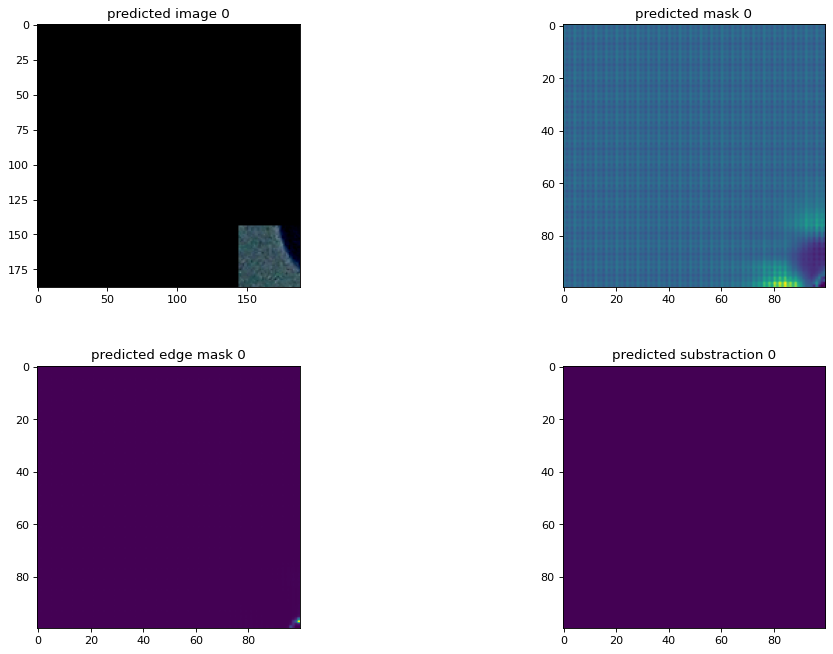

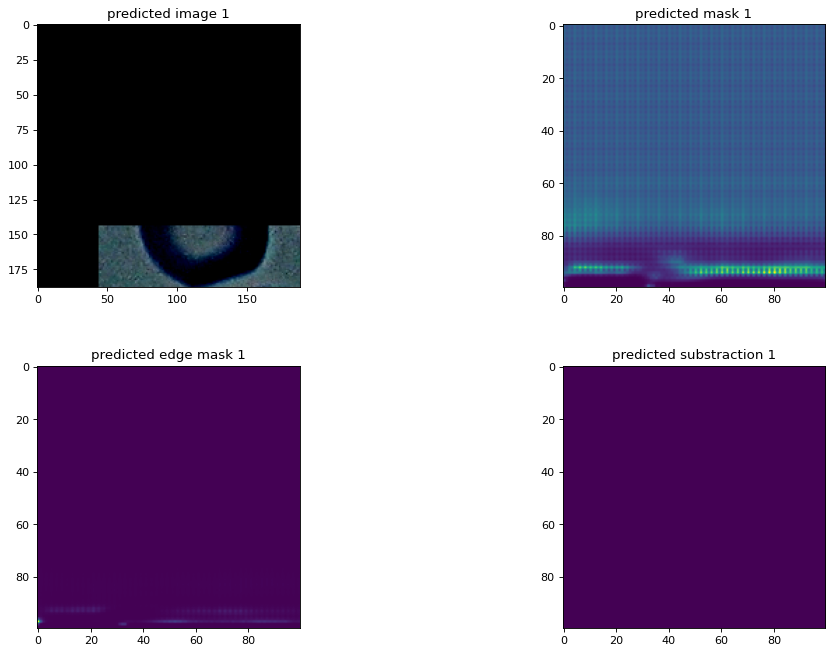

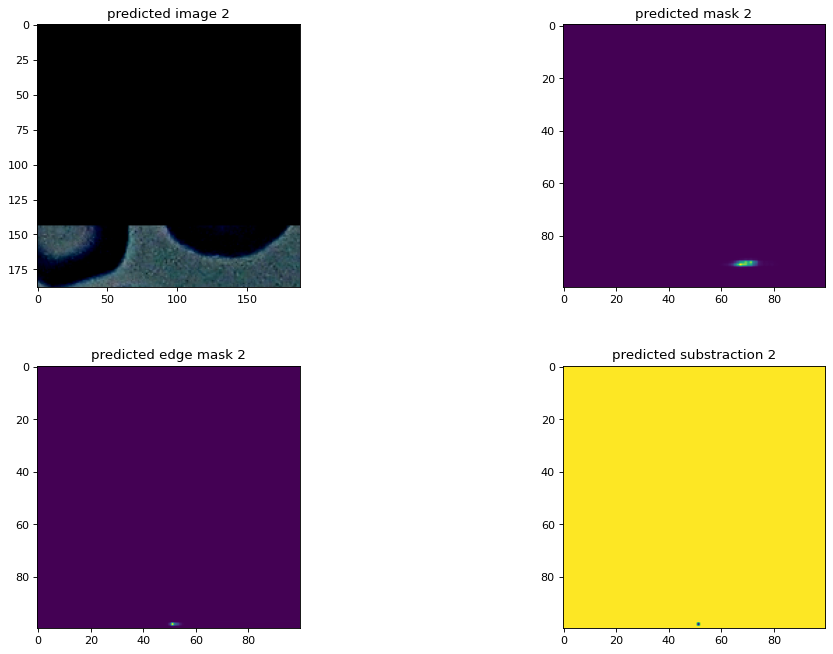

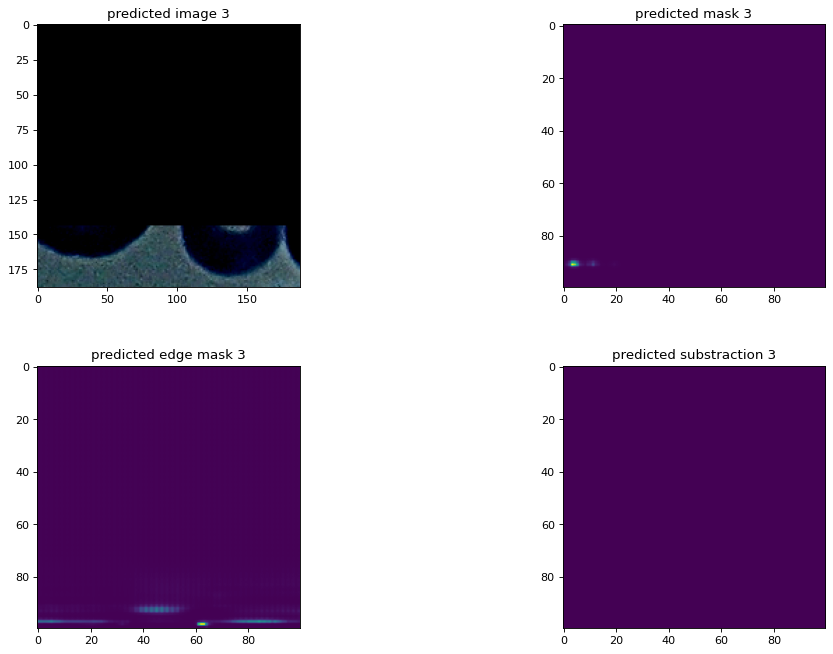

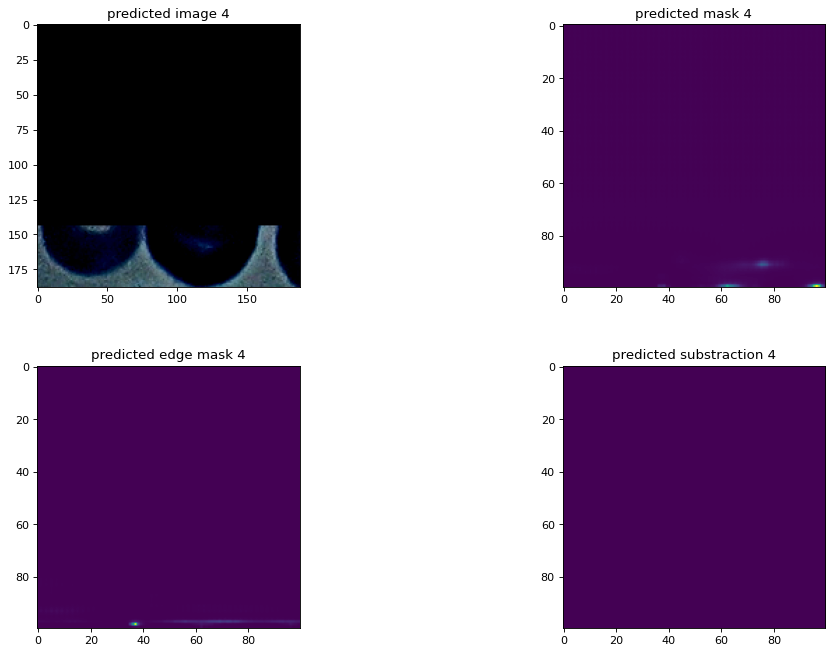

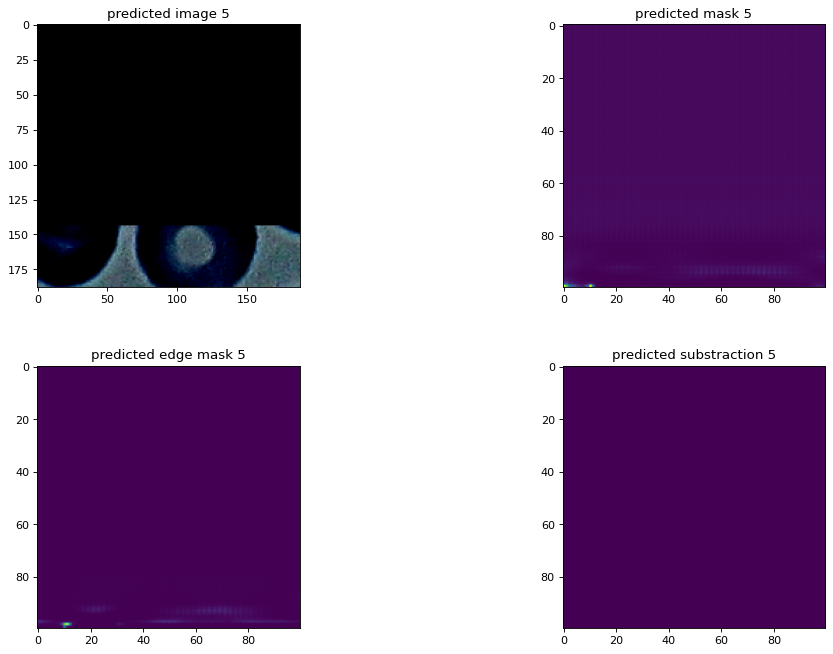

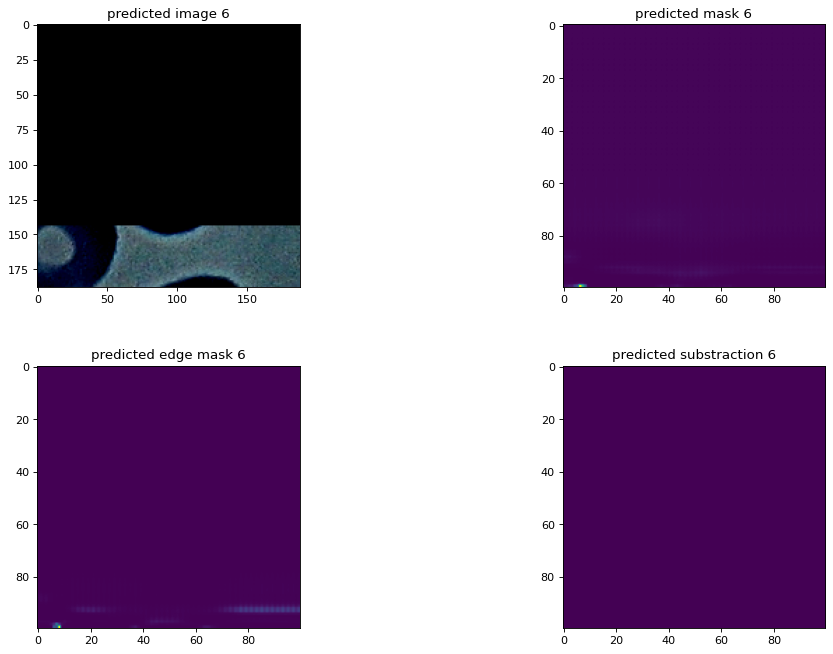

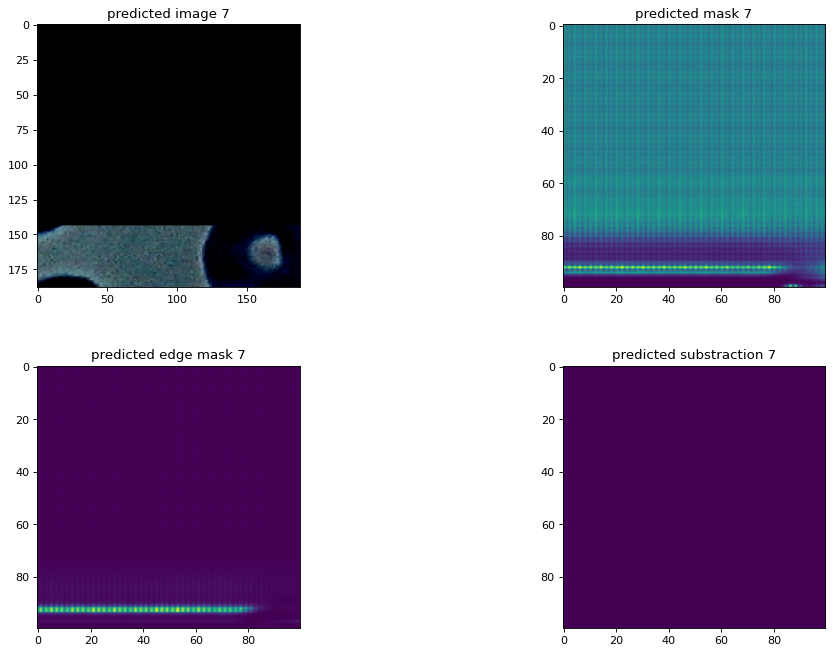

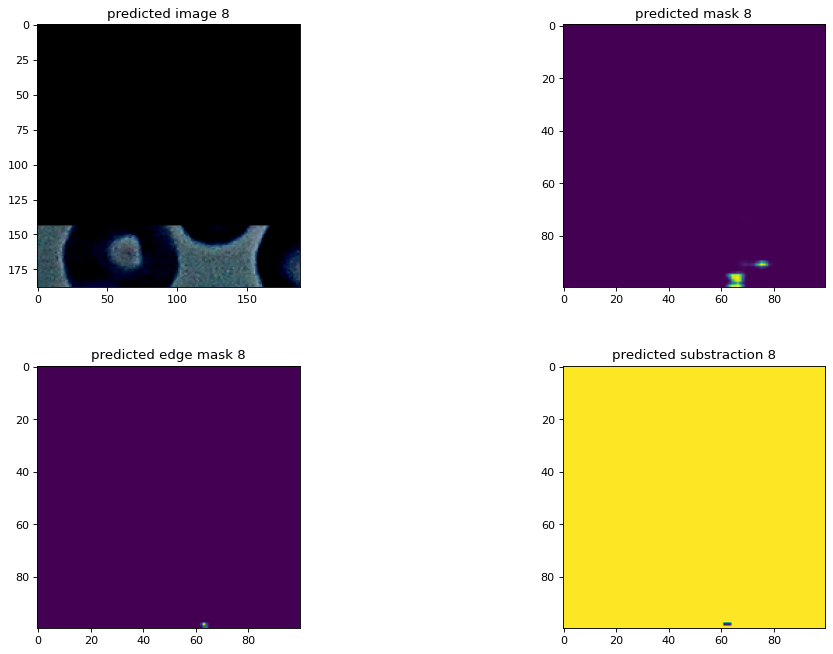

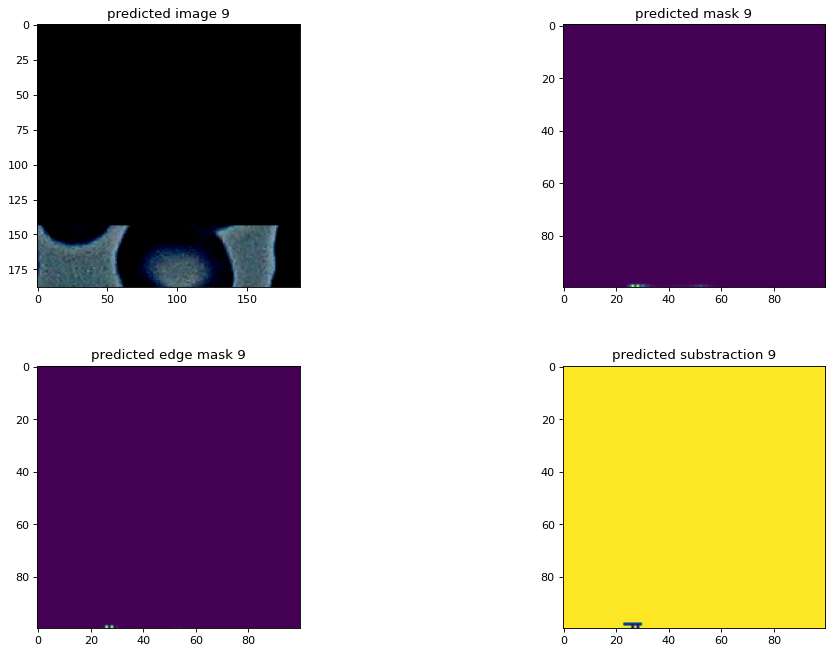

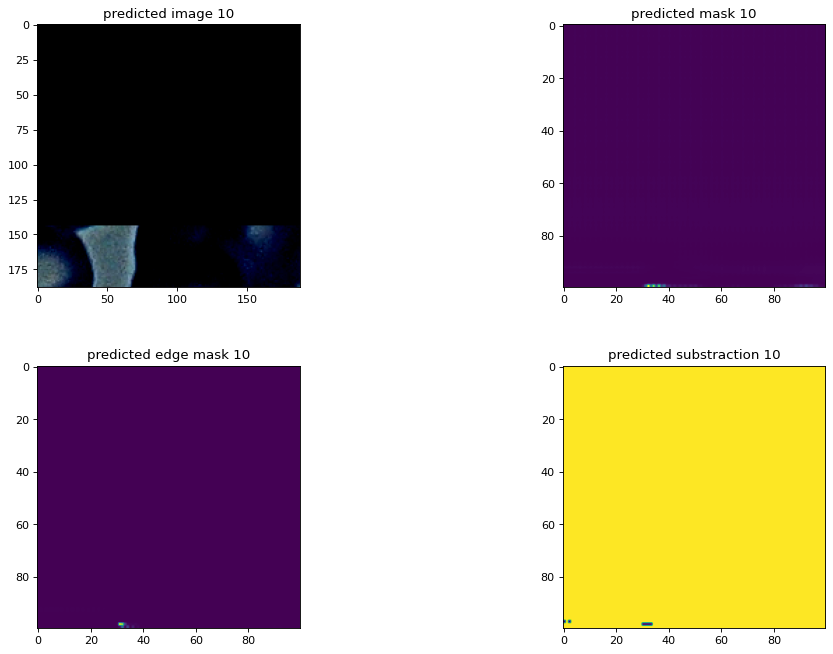

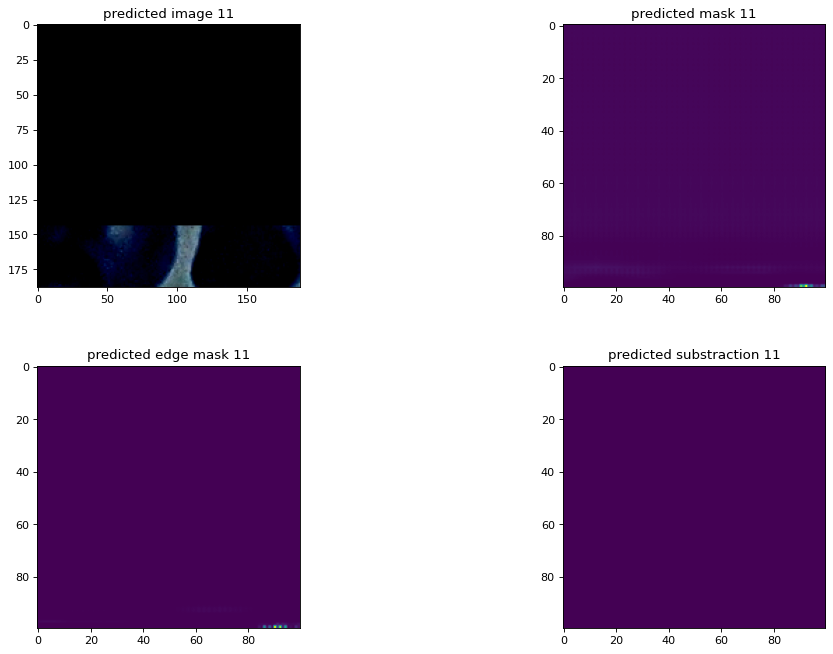

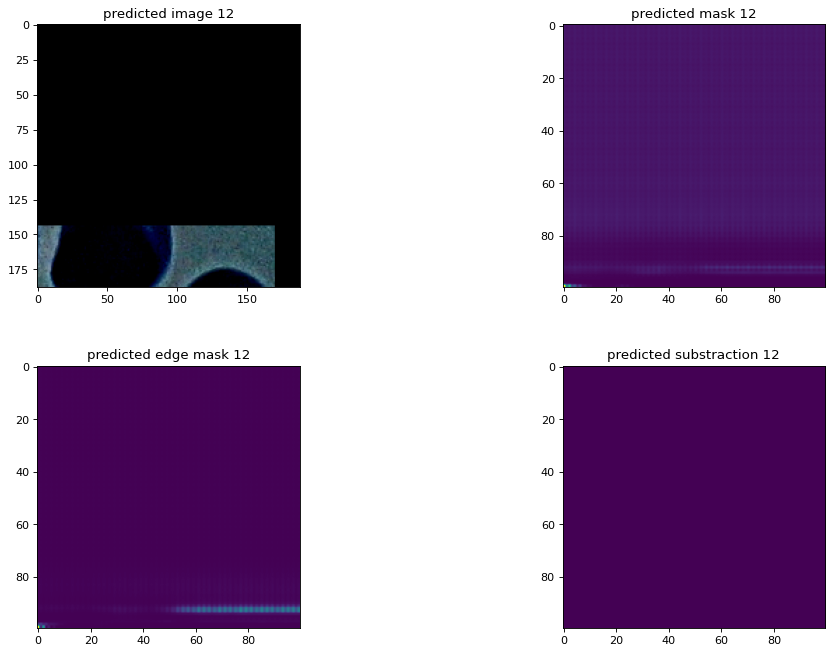

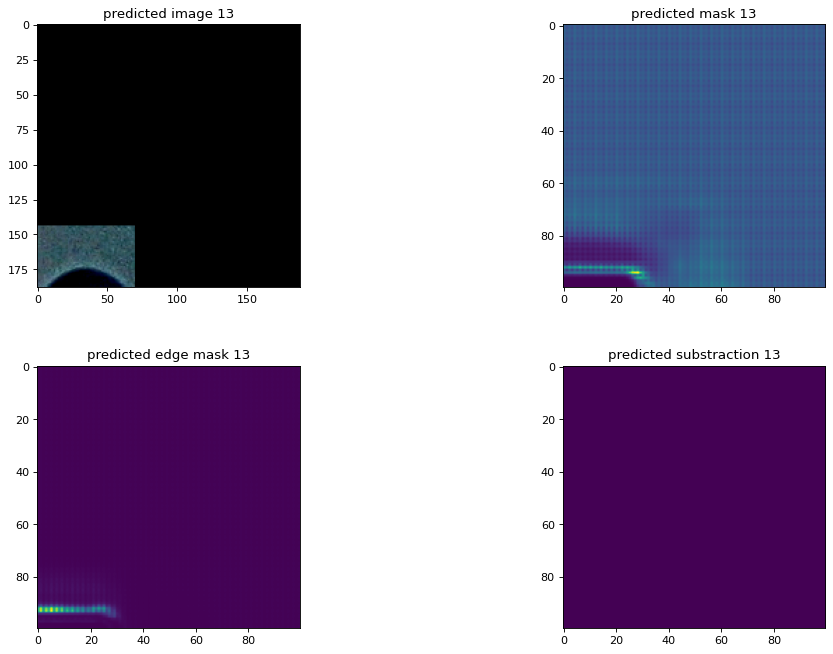

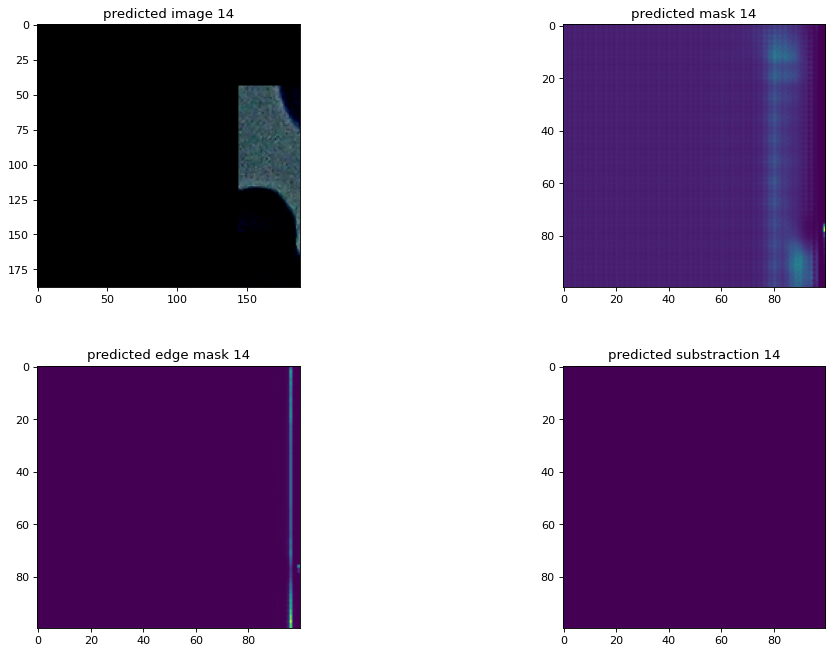

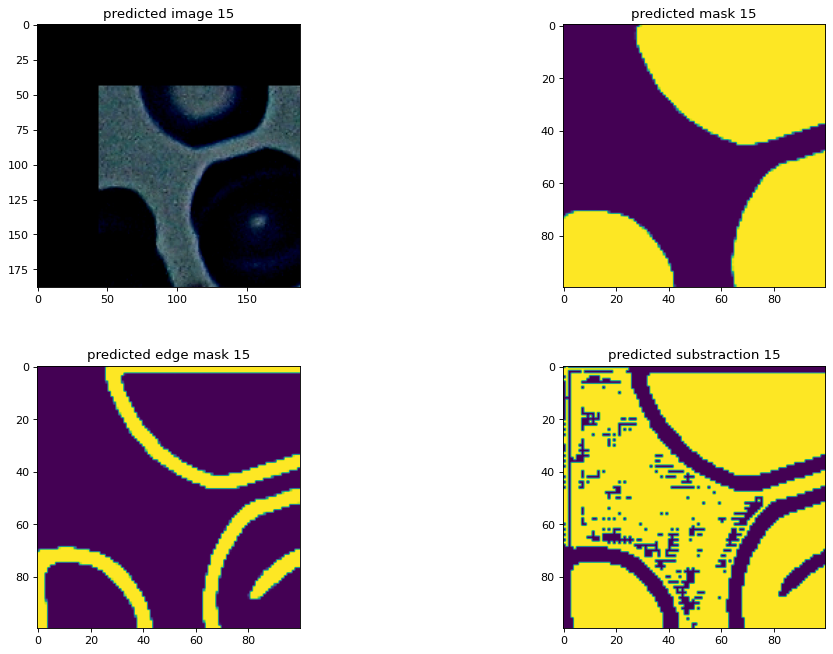

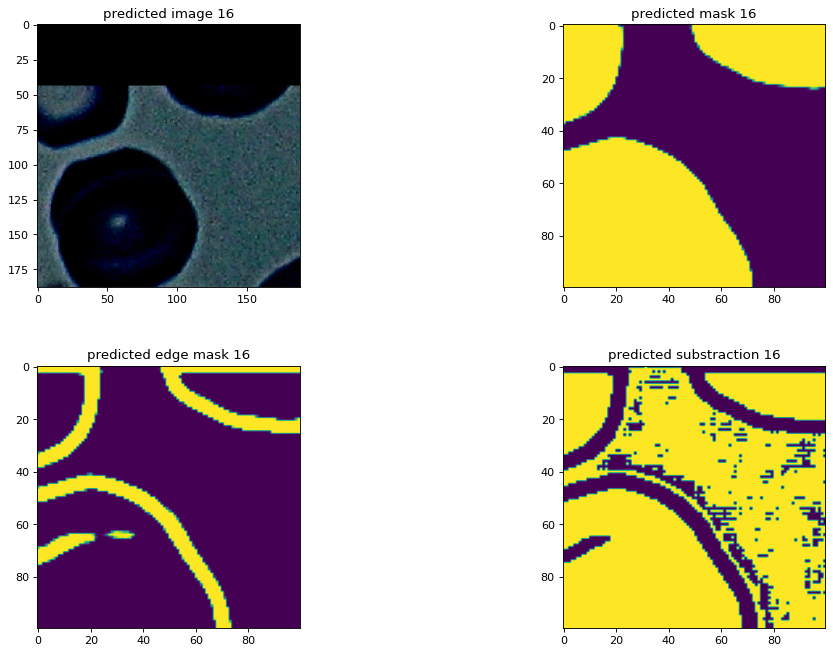

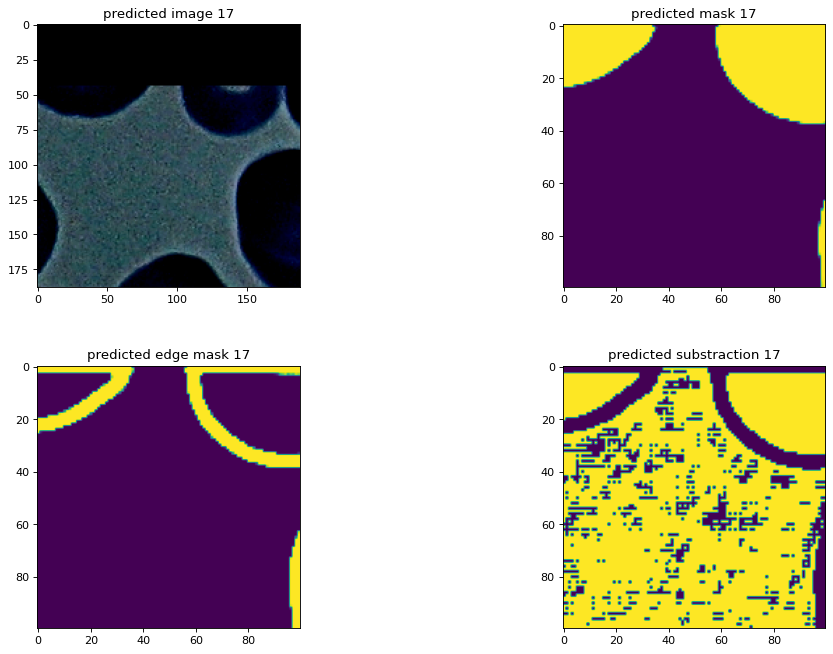

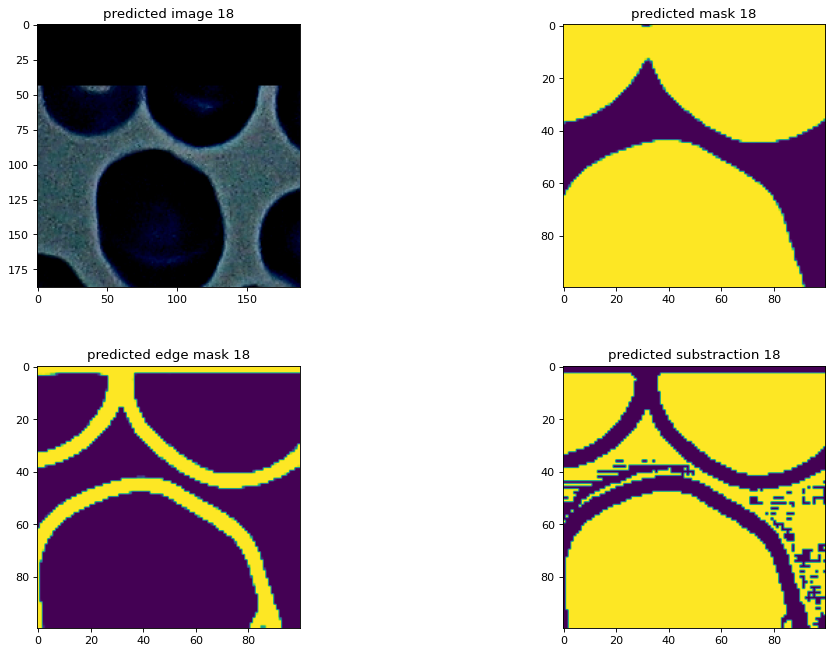

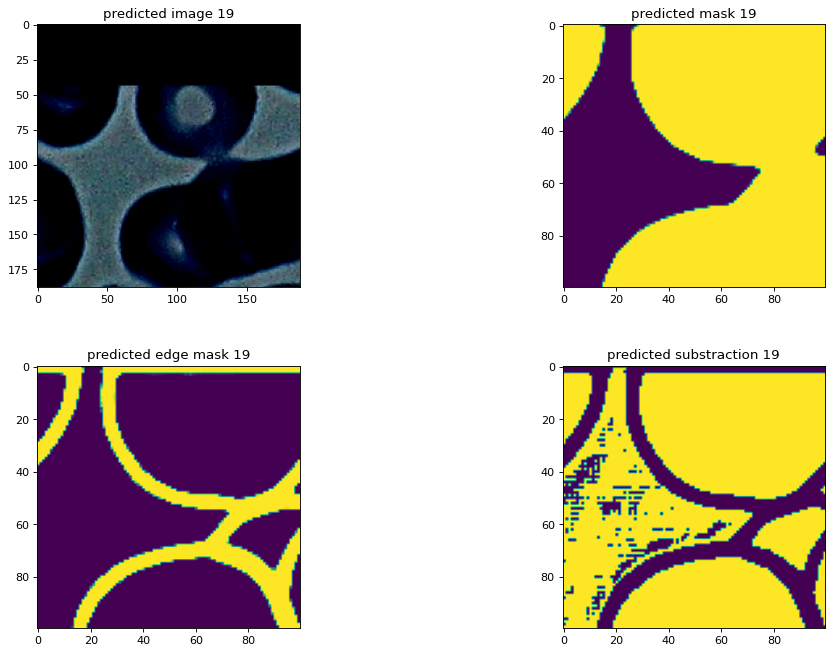

In [11]:
#rand_index = np.random.randint(0, len(test_img_chips), 1)[0]
#img = test_img_chips[rand_index]
#mask = np.squeeze(test_mask_chips[rand_index])
#edge = np.squeeze(test_edge_chips[rand_index])

test_img_chips, test_mask_chips, test_edge_chips = model.generate_test_dataset(test_img_files)


prediction = unet.predict(test_img_chips)

prediction = np.squeeze(prediction)

data.plot_ime(test_img_chips, prediction[0], prediction[1])



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


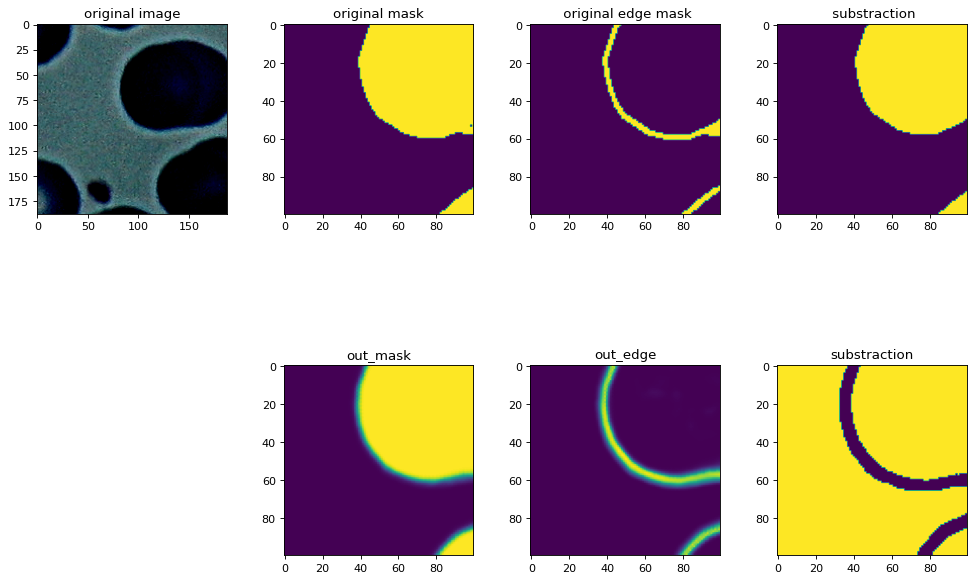

In [16]:
fig = plt.figure(figsize=(15, 10), dpi=80)
fig.subplots_adjust(hspace=0.3, wspace=0.3)
fig_num = 1
ax = fig.add_subplot(2, 4, fig_num)
ax.set_title("original image")
ax.imshow(img[0])
fig_num = fig_num + 1
ax = fig.add_subplot(2, 4, fig_num)
ax.set_title("original mask")
ax.imshow(mask)
fig_num = fig_num + 1
ax = fig.add_subplot(2, 4, fig_num)
ax.set_title(" original edge mask")
ax.imshow(edge)
fig_num = fig_num + 1
ax = fig.add_subplot(2, 4, fig_num)
ax.set_title(" substraction")
ax.imshow((mask - edge) > 0)


fig_num = fig_num + 2
ax = fig.add_subplot(2, 4, fig_num)
ax.set_title("out_mask")
ax.imshow(prediction[0])
fig_num = fig_num + 1
ax = fig.add_subplot(2, 4, fig_num)
ax.set_title("out_edge")
ax.imshow(prediction[1])
fig_num = fig_num + 1
ax = fig.add_subplot(2, 4, fig_num)
ax.set_title("substraction")
ax.imshow((prediction[0] - prediction[1]) > 0)




- predict full image

In [ ]:
images, masks, edges = model.predictFullImage(unet,
                          data.load_data_na(test_img_files, RGB=True, clahe=True),
                        padding=100,
                        input_size=188,
                        output_size=100,
                        normalize_output = False)

In [ ]:
data.plot_ime(images,
              masks,
              edges,
              figSize=(25,15))

## model training data plot

In [ ]:
hist = history.history

lines = 4
columns = 3

fig = plt.figure(figsize=(20, 20), dpi=80)
fig.subplots_adjust(hspace=0.3, wspace=0.3)
fig_num = 1
ax = fig.add_subplot(lines, columns, fig_num)
ax.set_title("mask accuracy")
ax.plot(hist['mask_acc'], label="Training")
ax.plot(hist['val_mask_acc'], label="Validation")
ax.legend()
fig_num = fig_num + 1
ax = fig.add_subplot(lines, columns, fig_num)
ax.set_title("edge mask accuracy")
ax.plot(hist['edge_acc'], label="Training")
ax.plot(hist['val_edge_acc'], label="Validation")
ax.legend()
fig_num = fig_num + 2
ax = fig.add_subplot(lines, columns, fig_num)
ax.set_title("mask loss")
ax.plot(hist['mask_loss'], label="Training")
ax.plot(hist['val_mask_loss'], label="Validation")
ax.legend()
fig_num = fig_num + 1
ax = fig.add_subplot(lines, columns, fig_num)
ax.set_title("edge loss")
ax.plot(hist['edge_loss'], label="Training")
ax.plot(hist['val_edge_loss'], label="Validation")
ax.legend()

fig_num = fig_num + 1
ax = fig.add_subplot(lines, columns, fig_num)
ax.set_title("global loss")
ax.plot(hist['loss'], label="Training")
ax.plot(hist['val_loss'], label="Validation")
ax.legend()


fig_num = fig_num + 1
ax = fig.add_subplot(lines, columns, fig_num)
ax.set_title("mask metrics")
ax.plot(hist['mask_dsc'], label="dsc")
ax.plot(hist['mask_mean_iou'], label="mean iou")
ax.plot(hist['mask_tversky'], label="tversky")
ax.plot(hist['mask_acc'], label="accuracy")

ax.set_title("mask metrics")
ax.plot(hist['val_mask_dsc'], label="val_dsc")
ax.plot(hist['val_mask_mean_iou'], label="val_mean iou")
ax.plot(hist['val_mask_tversky'], label="val_tversky")
ax.plot(hist['val_mask_acc'], label="val_accuracy")

fig_num = fig_num + 1
ax = fig.add_subplot(lines, columns, fig_num)
ax.set_title("edge metrics")
ax.plot(hist['edge_dsc'], label="dsc")
ax.plot(hist['edge_mean_iou'], label="mean iou")
ax.plot(hist['edge_tversky'], label="tversky")
ax.plot(hist['edge_acc'], label="accuracy")

ax.set_title("edge metrics")
ax.plot(hist['val_edge_dsc'], label="val_dsc")
ax.plot(hist['val_edge_mean_iou'], label="val_mean iou")
ax.plot(hist['val_edge_tversky'], label="val_tversky")
ax.plot(hist['val_edge_acc'], label="val_accuracy")
ax.legend()

## For Debugging
- show in between layers output

In [17]:
ind = np.random.randint(0, 32, 1)[0]

_pool1 = pool1[:-1,:-1,ind]
_pool2 = pool2[:-1,:-1,ind]
_pool3 = pool3[:-1,:-1,ind]
_down4 = down4[:-1,:-1,ind]
_up1 = up1[:-1,:-1,ind]
_up2 = up2[:-1,:-1,ind]
_up3 = up3[:-1,:-1,ind]

fig = plt.figure(figsize=(15, 10), dpi=80)
fig.subplots_adjust(hspace=0.3, wspace=0.3)
fig_num = 1
ax = fig.add_subplot(3, 3, fig_num)
ax.set_title("out_mask")
ax.imshow(out_mask)
fig_num = fig_num + 1
ax = fig.add_subplot(3, 3, fig_num)
ax.set_title("out_edge")
ax.imshow(out_edge)
fig_num = fig_num + 1
ax = fig.add_subplot(3, 3, fig_num)
ax.set_title("pool1")
ax.imshow(_pool1)
fig_num = fig_num + 1
ax = fig.add_subplot(3, 3, fig_num)
ax.set_title("pool2")
ax.imshow(_pool2)
fig_num = fig_num + 1
ax = fig.add_subplot(3, 3, fig_num)
ax.set_title("pool3")
ax.imshow(_pool3)
fig_num = fig_num + 1
ax = fig.add_subplot(3, 3, fig_num)
ax.set_title("down4")
ax.imshow(_down4)
fig_num = fig_num + 1
ax = fig.add_subplot(3, 3, fig_num)
ax.set_title("up1")
ax.imshow(_up1)
fig_num = fig_num + 1
ax = fig.add_subplot(3, 3, fig_num)
ax.set_title("up2")
ax.imshow(_up2)
fig_num = fig_num + 1
ax = fig.add_subplot(3, 3, fig_num)
ax.set_title("up3")
ax.imshow(_up3)

NameError: name 'pool1' is not defined

- function to plot and array of images of shape (width, height, n_images)

In [ ]:
def picshow(img, title):
    num = img.shape[2]
    imgs_per_line = 4
    ax = num//imgs_per_line + 1
    ay = imgs_per_line
    fig =plt.figure(figsize=(30, num//imgs_per_line * 10))
    fig.subplots_adjust(hspace=0.1, wspace=0.1)
    for i in range(1,num + 1):
        sub = fig.add_subplot(ax,ay,i)
        sub.set_title(f"{title} {i}")
        sub.imshow(img[:-1,:-1,i - 1])
    plt.show()
    



In [ ]:
picshow(pool1, 'pool1 ')
picshow(pool2, 'pool2 ')
picshow(pool3, 'pool3 ')
picshow(down4, 'down4 ')
picshow(up1, 'up1 ')
picshow(up2, 'up2 ')
picshow(up3, 'up3 ')